In [ ]:
import torch
from torchmetrics import ConfusionMatrix
import torchvision
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
from torchvision import datasets, transforms

import sys
from pathlib import Path
import os

sys.path.append("../")

import random
import json
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from classification.evaluate import predictions
from classification.model.model import create_efficientnet_b0
from classification.data.generate_lego_part_classes import get_part_classes

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Set path to data
data_path = Path("../data")

part_class_path: Path = Path("../classification/data")

image_paths: list[Path] = []
for root, dirs, _ in os.walk(data_path):
    for dir_name in dirs:
        folder_path: str = os.path.join(root, dir_name)
        subfolder_contents: list[str] = os.listdir(folder_path)

        if all(
            os.path.isfile(os.path.join(folder_path, item))
            for item in subfolder_contents
        ):
            image_paths.append(Path(root))
            break

cust_img_path = Path("C:/Users/chris/Documents/Images/lego/cropped_images")

image_path_list = list(itertools.chain.from_iterable([list(img_path.glob("*/*.jpg")) for img_path in image_paths]))
cust_img_path_list = list(cust_img_path.glob("*/*.jpg"))

image_paths, cust_img_path

([WindowsPath('../data/b200c-lego-classification-dataset'),
  WindowsPath('../data/real_image_dataset/Bars Ladders and Fences'),
  WindowsPath('../data/real_image_dataset/Bionicle Hero Factory and Constraction'),
  WindowsPath('../data/real_image_dataset/Bricks'),
  WindowsPath('../data/real_image_dataset/Bricks Curved'),
  WindowsPath('../data/real_image_dataset/Bricks Round and Cones'),
  WindowsPath('../data/real_image_dataset/Bricks Sloped'),
  WindowsPath('../data/real_image_dataset/Bricks Special'),
  WindowsPath('../data/real_image_dataset/Bricks Wedged'),
  WindowsPath('../data/real_image_dataset/Hinges Arms and Turntables'),
  WindowsPath('../data/real_image_dataset/Minifig Accessories'),
  WindowsPath('../data/real_image_dataset/Panels'),
  WindowsPath('../data/real_image_dataset/Plants and Animals'),
  WindowsPath('../data/real_image_dataset/Plates'),
  WindowsPath('../data/real_image_dataset/Plates Angled'),
  WindowsPath('../data/real_image_dataset/Plates Round Curved and 

In [ ]:
with open("../classification/data/part_classes.json", "r") as f:
        transform_dict = json.load(f)
transform_dict

{'30414': 5,
 '15672': 3,
 '87697': 29,
 '17114': 26,
 '10314': 37,
 '32124': 26,
 '4216': 5,
 '32013': 12,
 '41678': 12,
 '3009': 11,
 '25269': 67,
 '74261': 41,
 '32059': 49,
 '3024': 14,
 '32140': 51,
 '92579': 47,
 '3034': 14,
 '98283': 5,
 '94161': 16,
 '48723': 12,
 '64225': 6,
 '14417': 9,
 '2412b': 15,
 '3032': 14,
 '4589': 20,
 '3185': 32,
 '4282': 14,
 '57909b': 26,
 '3679': 18,
 '92582': 18,
 '3065': 11,
 '48092': 20,
 '6182': 37,
 '3035': 14,
 '18677': 9,
 '60475b': 5,
 '10197': 12,
 '23969': 23,
 '3028': 14,
 '43898': 21,
 '88646': 9,
 '54383': 49,
 '60484': 51,
 '14720': 55,
 '14716': 11,
 '60581': 23,
 '30357': 21,
 '32526': 51,
 '4286': 3,
 '3045': 3,
 '3710': 14,
 '14704': 9,
 '32952': 5,
 '3022': 14,
 '47457': 37,
 '11478': 51,
 '2921': 5,
 '22961': 12,
 '32525': 51,
 '3713': 54,
 '3633': 32,
 '73983': 18,
 '4742': 20,
 '64391': 40,
 '15395': 20,
 '27925': 67,
 '4865b': 23,
 '60478': 9,
 '32192': 12,
 '32523': 51,
 '92589': 32,
 '41532': 18,
 '6141': 21,
 '98262': 28,

In [5]:
# Creating file with part id classes if not already created
part_ids: list[str] = sorted(
    set([part for img_path in image_paths for part in os.listdir(img_path)])
)
class_names: list[str] = []

if "part_classes.json" in os.listdir(part_class_path):
    print(
        f"'part_classes.json' is already in target directory. Assuming part classes are already created!"
    )
else:
    get_part_classes(
        data_path=data_path, save_path=(part_class_path / "part_classes.json")
    )

with open(part_class_path / "part_classes.json", "r") as file:
    class_dict: dict[str, int] = json.load(file)
    for id in part_ids:
        part_class = str(class_dict[id])
        if part_class not in class_names:
            class_names.append(part_class)
class_names.sort()

len(class_names)

'part_classes.json' is already in target directory. Assuming part classes are already created!


37

In [6]:
class_set = list(set(class_dict.values()))
class_dict_idx = {
    part: class_set.index(part_class) for part, part_class in class_dict.items()
}

class_names_conv = [str(i) for i in class_set]

class_names_conv

['3',
 '5',
 '6',
 '8',
 '9',
 '11',
 '12',
 '14',
 '15',
 '16',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '25',
 '26',
 '27',
 '28',
 '29',
 '32',
 '35',
 '36',
 '37',
 '40',
 '41',
 '46',
 '47',
 '49',
 '51',
 '52',
 '53',
 '54',
 '55',
 '67',
 '68']

In [ ]:
effnet_sorter, weights = create_efficientnet_b0(class_names=class_names, device=device)
effnet_sorter.load_state_dict(torch.load(f="../models/classification/batch_1/efficientnet_b0_lego_sorter.pt"))

C:\Users\chris\AppData\Local\Temp\ipykernel_20428\2332327633.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch1_test_sorter.load_state_dict(torch.load(f="../models/b

<All keys matched successfully>

In [8]:
image_transform = weights.transforms()

image_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
class PartSortingDataset(datasets.ImageFolder):       
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(idx_to_class[target])

        return sample, target
    
    def __len__(self):
        return len(self.samples)

In [ ]:
# Make data folder into dataset
temp_dataset = datasets.ImageFolder(root=image_paths[-2])

def _target_transformation(x):
    return transform_dict[x]

target_transform = transforms.Lambda(_target_transformation)

independent_datasets: list[PartSortingDataset] = []
for path in image_paths:
    independent_datasets.append(
        PartSortingDataset(
            root=path, transform=image_transform, target_transform=target_transform
        )
    )

full_dataset = ConcatDataset(independent_datasets)

print(f"Dataset length: {len(full_dataset)}")

sample, label = full_dataset[0]  # Access the first sample
print(f"Sample size: {sample.size()}, Label: {label}")

Dataset length: 1497613
Sample size: torch.Size([3, 224, 224]), Label: 9


In [ ]:
# Split into training and testing data
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_data, test_data = random_split(full_dataset, [train_size, test_size])

print(f"{len(train_data)}\n{len(test_data)}")

1198090
299523


In [40]:
BATCH_SIZE = 256
NUM_WORKERS = 0
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Make dataset into dataloader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

Creating DataLoader's with batch size 256 and 0 workers.


(4681, 1171)

Correct class:  14


WindowsPath('C:/Users/chris/Documents/Images/lego/cropped_images/3710/1_Plate_1x4_180709201325.jpg')

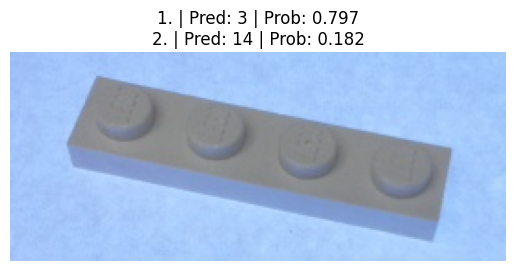

In [ ]:
random_image_path: Path = random.choice(cust_img_path_list)
predictions.pred_and_plot_image(model=effnet_sorter,
                    class_names=class_names_conv,
                    image_path=random_image_path,
                    transform=image_transform)
pred_idx = class_dict.get(str(random_image_path.parent.name))
print(f"Correct class:  {pred_idx}")

random_image_path

In [ ]:
from tqdm import tqdm

# 1. Make predictions with trained model
y_preds = []
effnet_sorter.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):

    X, y = X.to(device), y.to(device)

    y_logit = effnet_sorter(X)
    
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 1171/1171 [41:44<00:00,  2.14s/it]


In [69]:
idx_to_class = {idx: cl for d_set in full_dataset.datasets for cl, idx in d_set.class_to_idx.items()}

test_targets = torch.tensor([label for _, label in tqdm(test_data)])

test_targets

100%|██████████| 299523/299523 [13:27<00:00, 370.90it/s]


tensor([49,  3, 53,  ..., 51, 51, 21])

In [61]:
conv_y_pred_tensor = torch.tensor([int(class_names_conv[idx]) for idx in y_pred_tensor.tolist()])
conv_y_pred_tensor

tensor([49,  3, 53,  ..., 51, 51, 21])

In [70]:
len(set(torch.unique(test_targets).tolist()))

37

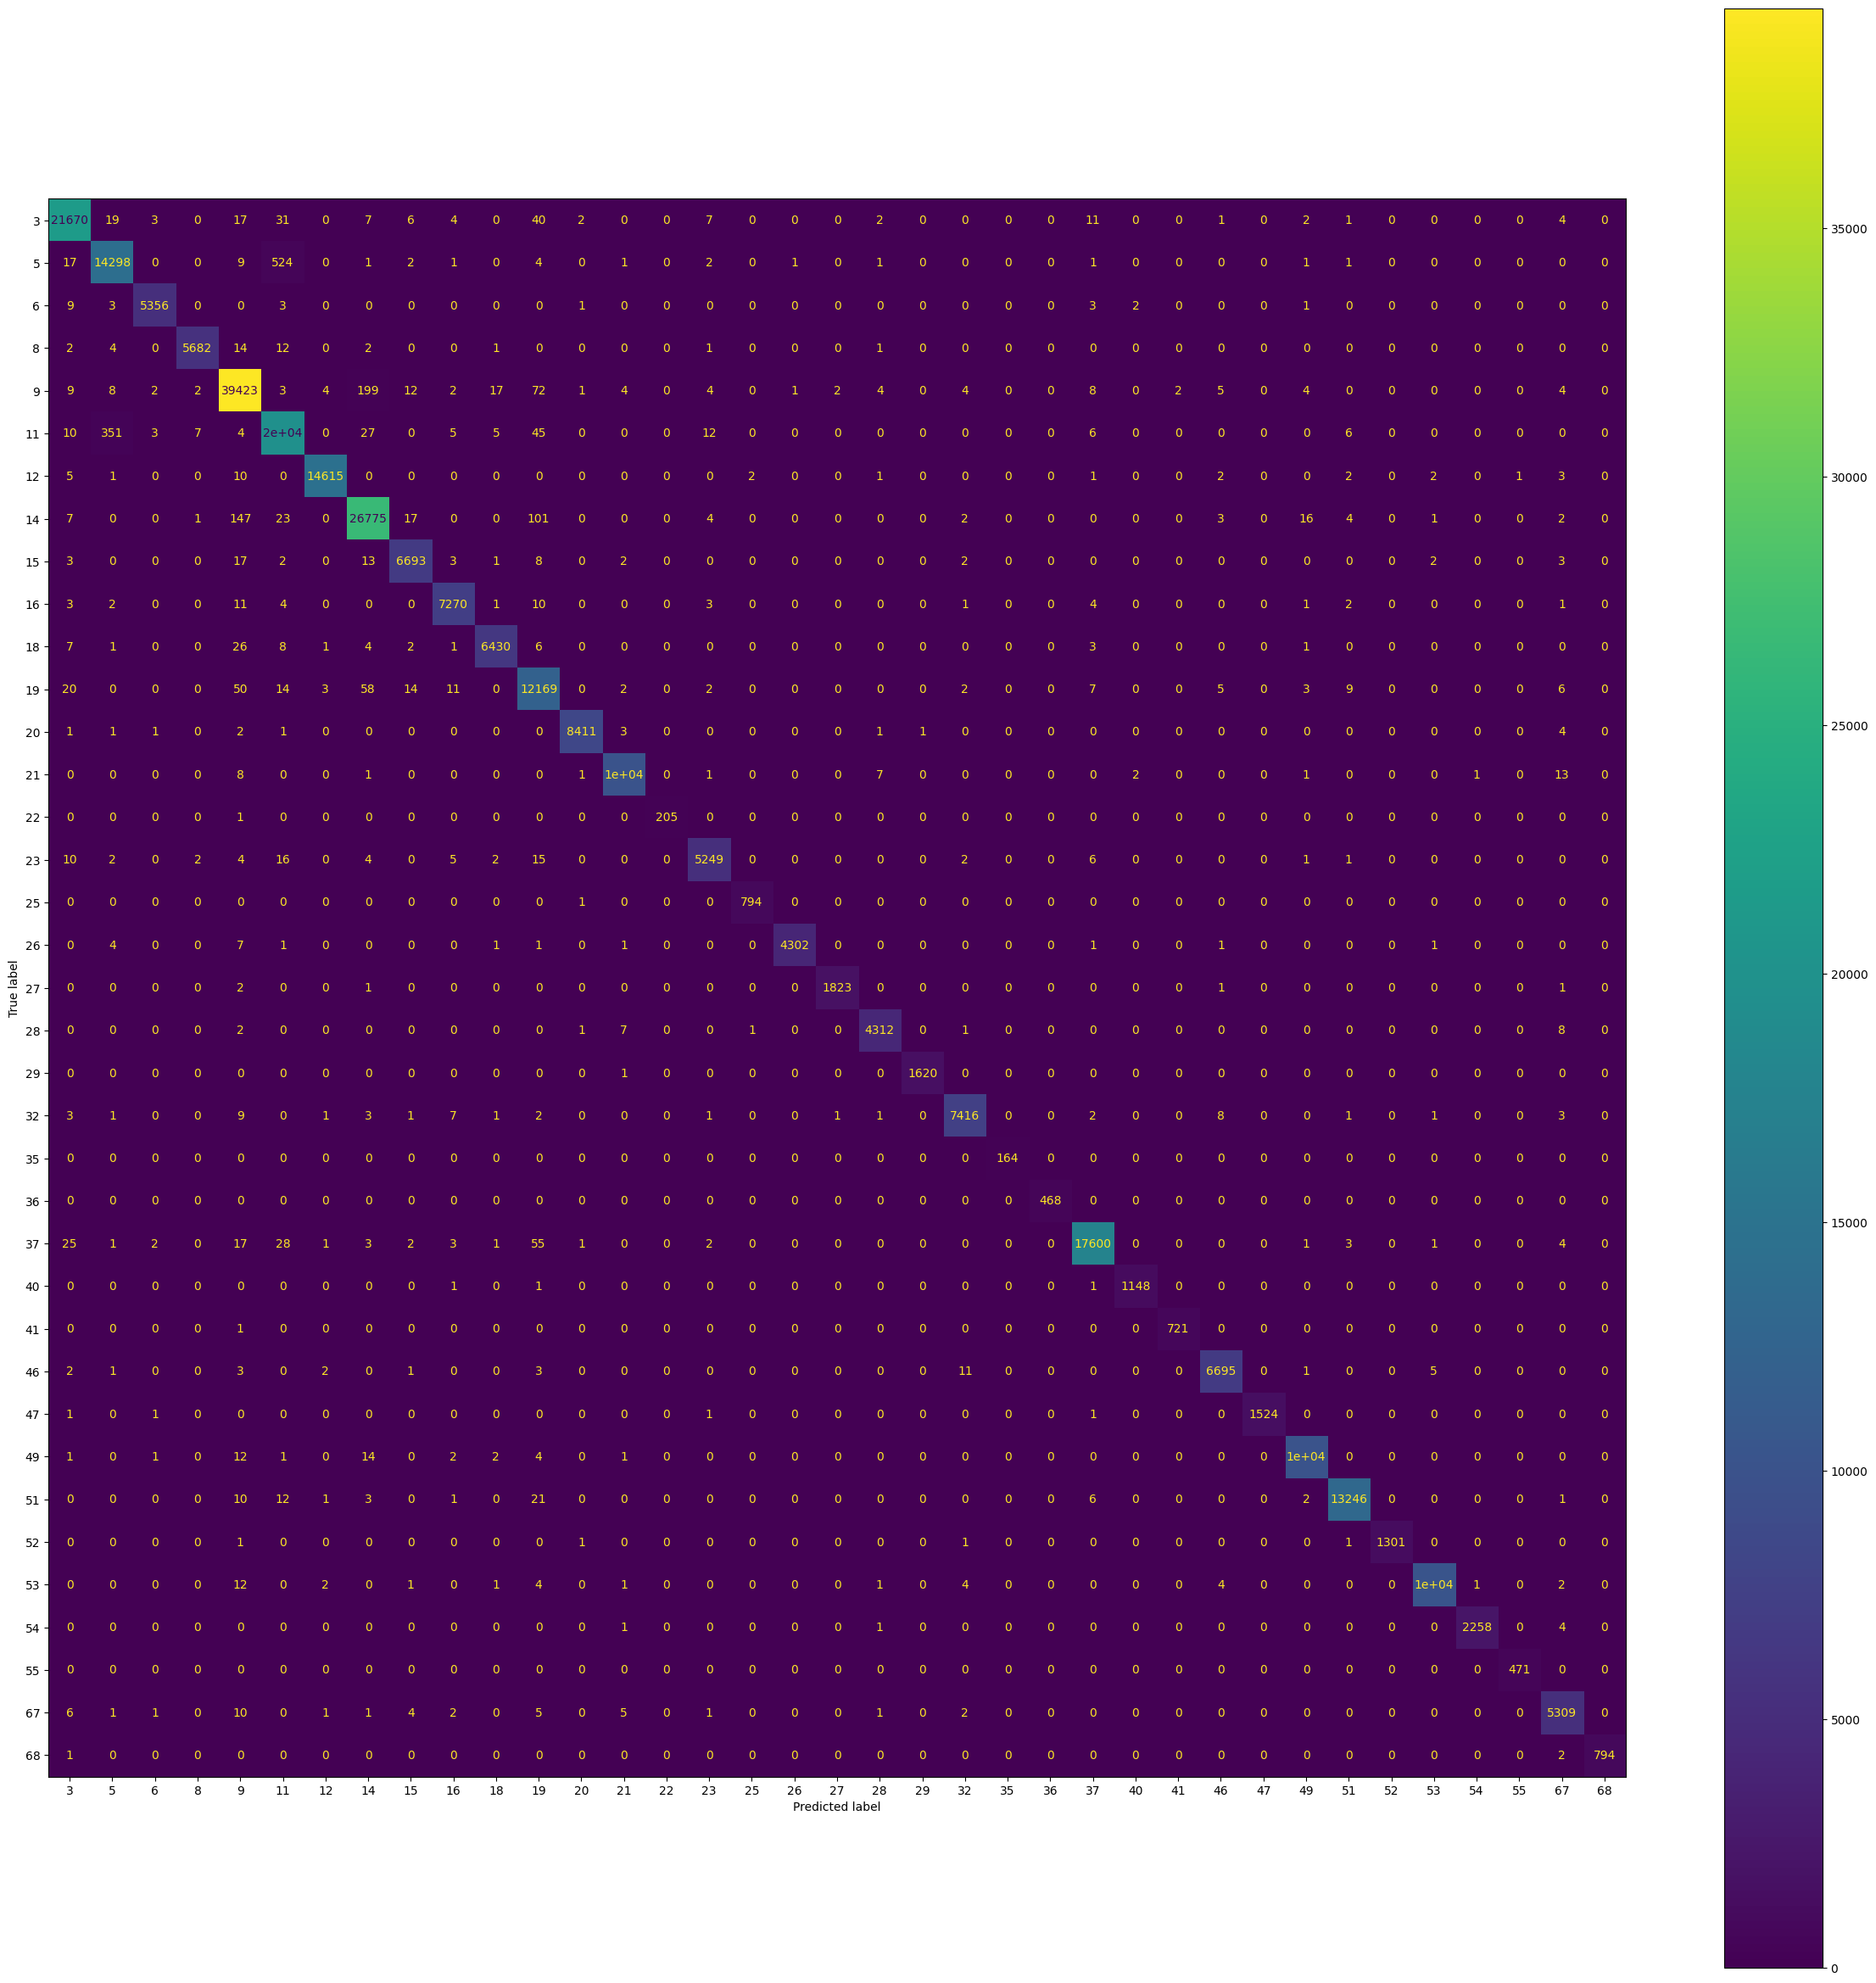

In [74]:
# Print a confusion matrix
cm = confusion_matrix(test_targets, conv_y_pred_tensor)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(torch.unique(test_targets).tolist()))

fig, ax = plt.subplots(figsize=(30, 30))
cmp.plot(ax=ax)